# Synthetic study

We followed the same reasoning and values to model the problem as in the **Stan-synthetic-study** file. But in this case we used another very powerful MCMC sampling software, called Timedeppar written by Peter Reichert of ETH Zurich. It is a R package specifically designed for Bayesian inference with time-dependent, stochastic parameters.

In [1]:
# import packages
install.packages('timedeppar')
install.packages('invgamma')
library(timedeppar)
library(invgamma)
seed = 12345

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: mvtnorm



In [2]:
# set colors 
col_red <- '#E21B1B'   #red
col_blue <- '#1769E6'  #blue
col_green <- '#00D10A' #green
col_grey <- '#C8CED0'  #gray

In [3]:
N_cycle <- 29
df_cycle <- read.csv('data/d18O_cycles.txt', header = T, sep = ',')

str(df_cycle)

'data.frame':	29 obs. of  5 variables:
 $ period  : num  4321 5973 6308 4792 5587 ...
 $ A       : num  0.178 0.172 0.151 0.148 0.129 ...
 $ sigma_A : num  0.0086 0.0098 0.0119 0.0077 0.0145 0.007 0.0095 0.0111 0.0074 0.0147 ...
 $ ph      : num  1.97 0.69 3.05 4.77 0.24 1.94 3.56 6.26 3.62 0.13 ...
 $ sigma_ph: num  0.04 0.11 0.12 0.1 0.17 0.1 0.15 0.19 0.18 0.13 ...


In [4]:
# cycles
period <- df_cycle[['period']]

# frequencies
freq <- 1/period

# Orstein-Uhlenbeck process
Timedeppar allows an Orstein-Uhlenbeck process to be simulated using the exact solution of the sthocastic equation. Note that in this case the package is designed such that we have to use $\gamma = 1/\tau$.

In [5]:
set.seed(seed)

# Orstein-Uhlenbeck parameters
mean <- 100
sd <- 5
dt <- 100
gamma <- 1/1500

# generate Orstein-Uhlenbeck
n <- 1429
data <- randOU(mean = mean, sd = sd, gamma = gamma, t = 1250 + seq(0, (n-1)*dt, dt), yini = mean)
colnames(data) <- c('step', 'xi')

cat('mean')
cat('\nexpected:', round(mean, 3),'yr','sample:', round(mean(data[['xi']]), 3),'yr')
cat('\nsd')
cat('\nexpected:', round(sd, 3),'yr','sample:', round(sqrt(var(data[['xi']])), 3),'yr')

mean
expected: 100 yr sample: 100.388 yr
sd
expected: 5 yr sample: 5.462 yr

In [65]:
# plot Orstein-Uhlenbeck model
plot_OU <- function(df, start, end) {

    df = df[start:end,]

    # plot
    options(repr.plot.width = 20, repr.plot.height = 8)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    plot(df$step, df$xi, ylim = mean + 5*c(-sd, sd),
        main = 'Simulated Orstein-Uhlenbeck',
        xlab = 't_reg [YBP]', ylab = 'ξ [yr]',
        type = 'l', lty = 1, lwd = 2, col = col_blue,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL,
        lty = 2, col = col_grey, lwd = 2)

    abline(h = mean, col=col_red, lty=2, lwd=2)

}

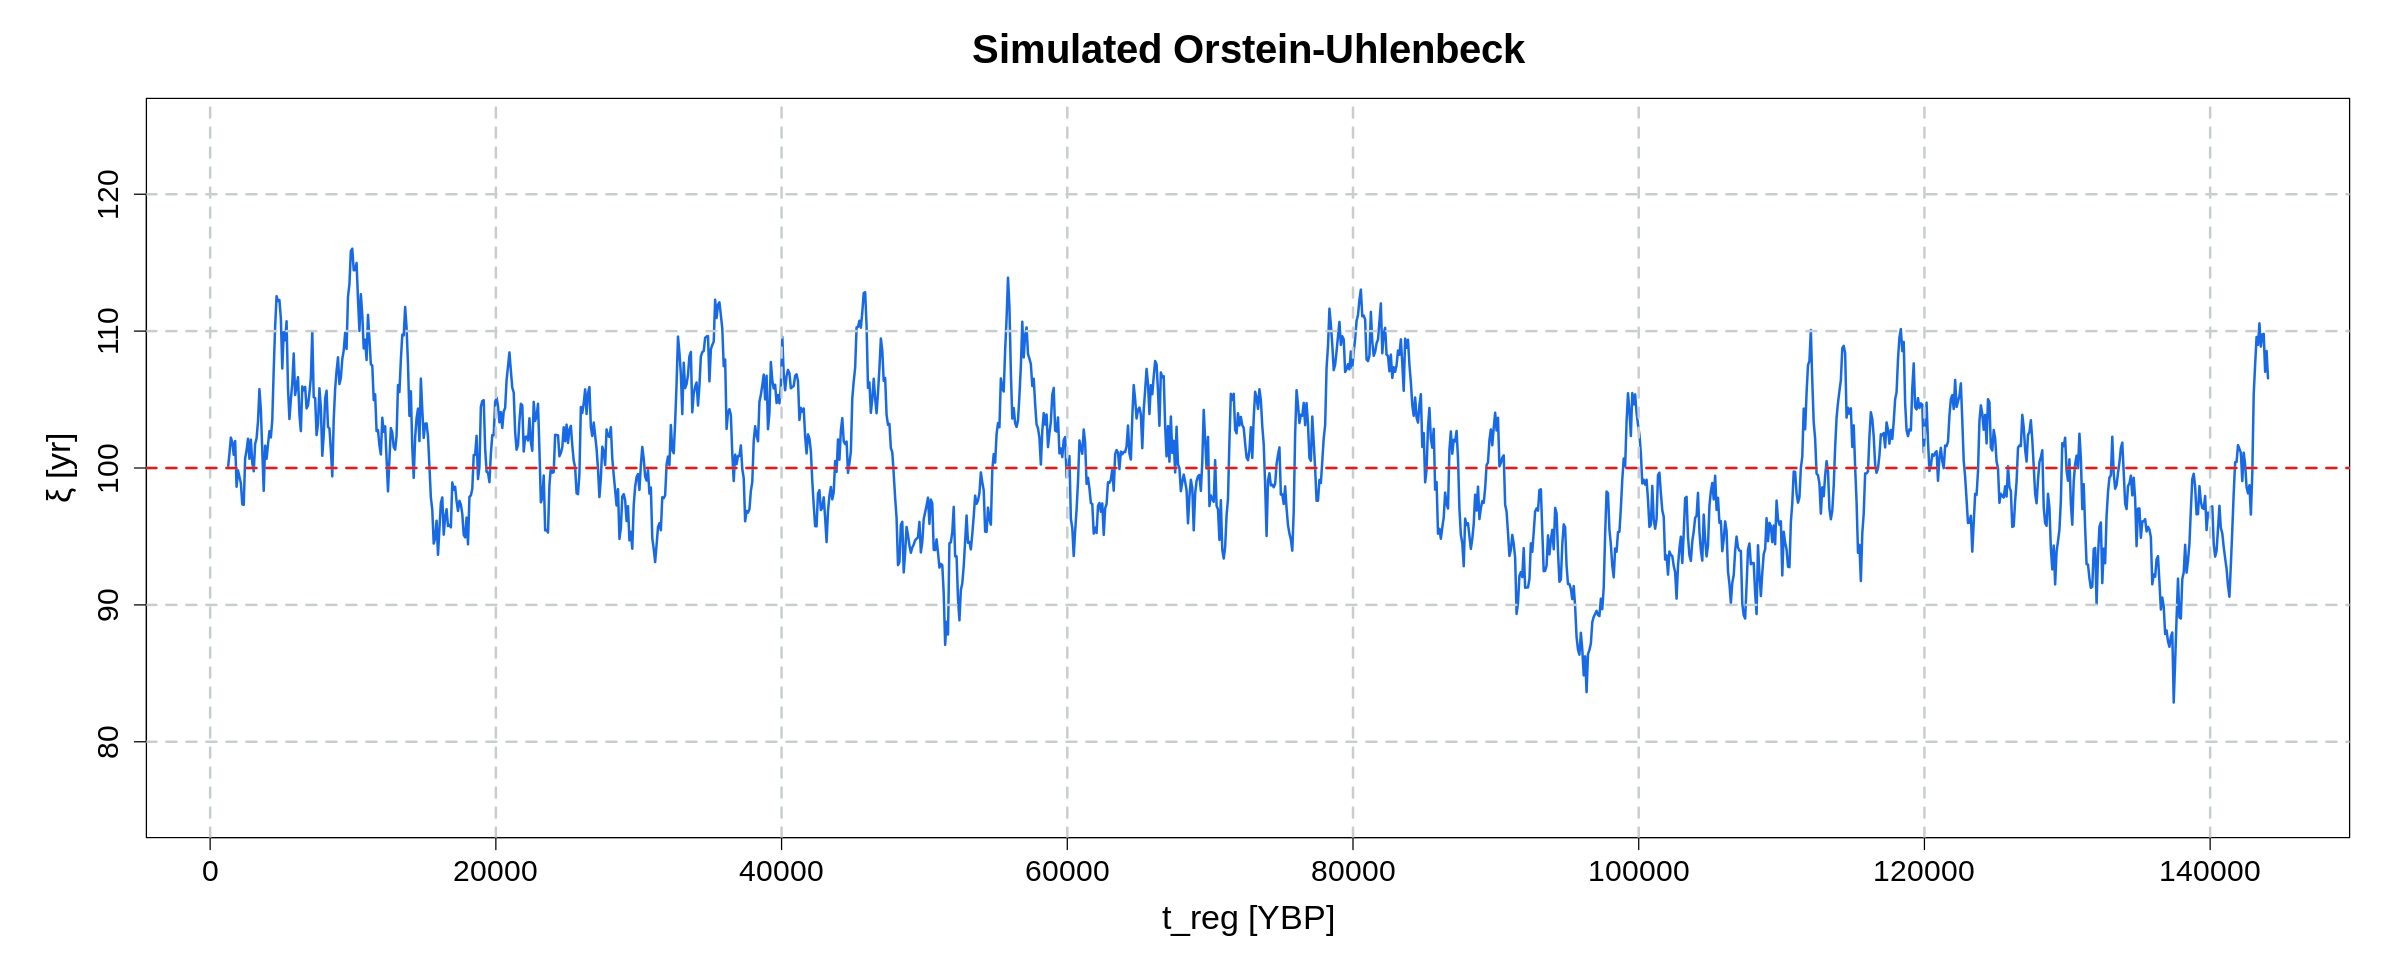

In [66]:
# plot Orstein-Uhlenbeck model
plot_OU(data, 1, n)

In [8]:
# corrupted time
t_corr <- rep(0, n)
t_corr[1] <- 1250
for (i in 2:n) {
        t_corr[i] <- t_corr[i-1] + data$xi[i]
}

# regular time
t_reg <- min(t_corr) + seq(0, 100*(n-1), 100)

In [9]:
set.seed(seed)

# amplitudes
A <- rnorm(N_cycle, mean = df_cycle[['A']], sd = df_cycle[['sigma_A']])

# phases
ph <- rnorm(N_cycle, mean = df_cycle[['ph']], sd = df_cycle[['sigma_ph']])
ph <- abs(ph)

# model corrupted
y_corr <- rep(0, length(t_corr))
for (i in 1:N_cycle) {
    y_corr <- y_corr + A[i]*cos(2*pi*freq[i]*t_corr + ph[i])
}

# model regular
y_reg <- rep(0, length(t_reg))
for (i in 1:N_cycle) {
    y_reg <- y_reg + A[i]*cos(2*pi*freq[i]*t_reg + ph[i])
}

# noise
sigma_y <- 0.2
noise = rnorm(n = n, mean = 0, sd = sigma_y)

# observed data
data$y_corr_obs <- y_corr + noise

In [10]:
# Orstein-Uhlenbeck parameters
param_OU <- c(mean, sd, gamma)
names(param_OU) <- c('xi_mean', 'xi_sd', 'xi_gamma')

# sigma_y parameter
param_sigma_y <- sigma_y
names(param_sigma_y) <- 'sigma_y'

# A parameters
param_A <- NULL
for (i in 1:N_cycle) {
    temp <- A[i]
    names(temp) <- paste0('A.',i)
    param_A <- append(param_A, temp) 
}

# ph parameters
param_ph <- NULL
for (i in 1:N_cycle) {
    temp <- ph[i]
    names(temp) <- paste0('ph.',i)
    param_ph <- append(param_ph, temp) 
}

# t parameters
param_t <- NULL
for (i in 1:n) {
    temp <- t_corr[i]
    names(temp) <- paste0('t.',i)
    param_t <- append(param_t, temp) 
}

# concatenate named vectors
param <- c(param_OU, param_sigma_y, param_A, param_ph)

for (name in names(param)) {
    if (name == 'xi_gamma') {
        cat(name, ': ', round(param[name], 6), '\n', sep = '')
    }
    else {
        cat(name, ': ', round(param[name], 4), '\n', sep = '')
    }
}

xi_mean: 100
xi_sd: 5
xi_gamma: 0.000667
sigma_y: 0.2
A.1: 0.1832
A.2: 0.1789
A.3: 0.1496
A.4: 0.1443
A.5: 0.1376
A.6: 0.1124
A.7: 0.1242
A.8: 0.1088
A.9: 0.1096
A.10: 0.095
A.11: 0.1052
A.12: 0.118
A.13: 0.1024
A.14: 0.1029
A.15: 0.0843
A.16: 0.0979
A.17: 0.078
A.18: 0.0846
A.19: 0.0926
A.20: 0.0781
A.21: 0.0814
A.22: 0.0884
A.23: 0.0649
A.24: 0.057
A.25: 0.0601
A.26: 0.0874
A.27: 0.0593
A.28: 0.0668
A.29: 0.0639
ph.1: 1.9635
ph.2: 0.7793
ph.3: 3.3136
ph.4: 4.9749
ph.5: 0.5175
ph.6: 1.9654
ph.7: 3.6337
ph.8: 6.1984
ph.9: 3.3208
ph.10: 0.3598
ph.11: 0.7365
ph.12: 5.6793
ph.13: 2.3539
ph.14: 4.251
ph.15: 2.8637
ph.16: 3.8636
ph.17: 6.4659
ph.18: 0.5826
ph.19: 4.7335
ph.20: 1.5658
ph.21: 0.058
ph.22: 0.0633
ph.23: 0.7806
ph.24: 1.3818
ph.25: 6.2233
ph.26: 5.7554
ph.27: 5.4923
ph.28: 2.0843
ph.29: 4.4872


In [81]:
# plot simulation
plot_simulation <- function(t_reg, y_reg, data, start, end) {

    t_reg = t_reg[start:end]
    y_reg = y_reg[start:end]
    data = data[start:end,]

    # plot
    options(repr.plot.width = 21, repr.plot.height = 7)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    plot(t_reg, data$y_corr_obs, ylim = (max(y_reg) + 3*sigma_y)*c(-1,1),
        main = 'Simulated dataset with time-scale corruption',
        xlab = 't_reg [YBP]', ylab = 'y [‰]',
        type = 'l', lty = 1, lwd = 2, col = col_blue,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL,
        lty = 2, col = col_grey, lwd = 2)

    lines(t_reg, y_reg, type = 'l', lty = 1, lwd = 2, col = col_red)

    legend(x = start*100 + 0.71*(end-start)*100, y = 1.55, bty = 'n',
        inset = 0.02,
        legend = c('observed data', 'generative model'),
        lty = rep(1,2),
        col = c(col_blue, col_red),
        lwd = rep(2,2),
        cex = 1.3)

}

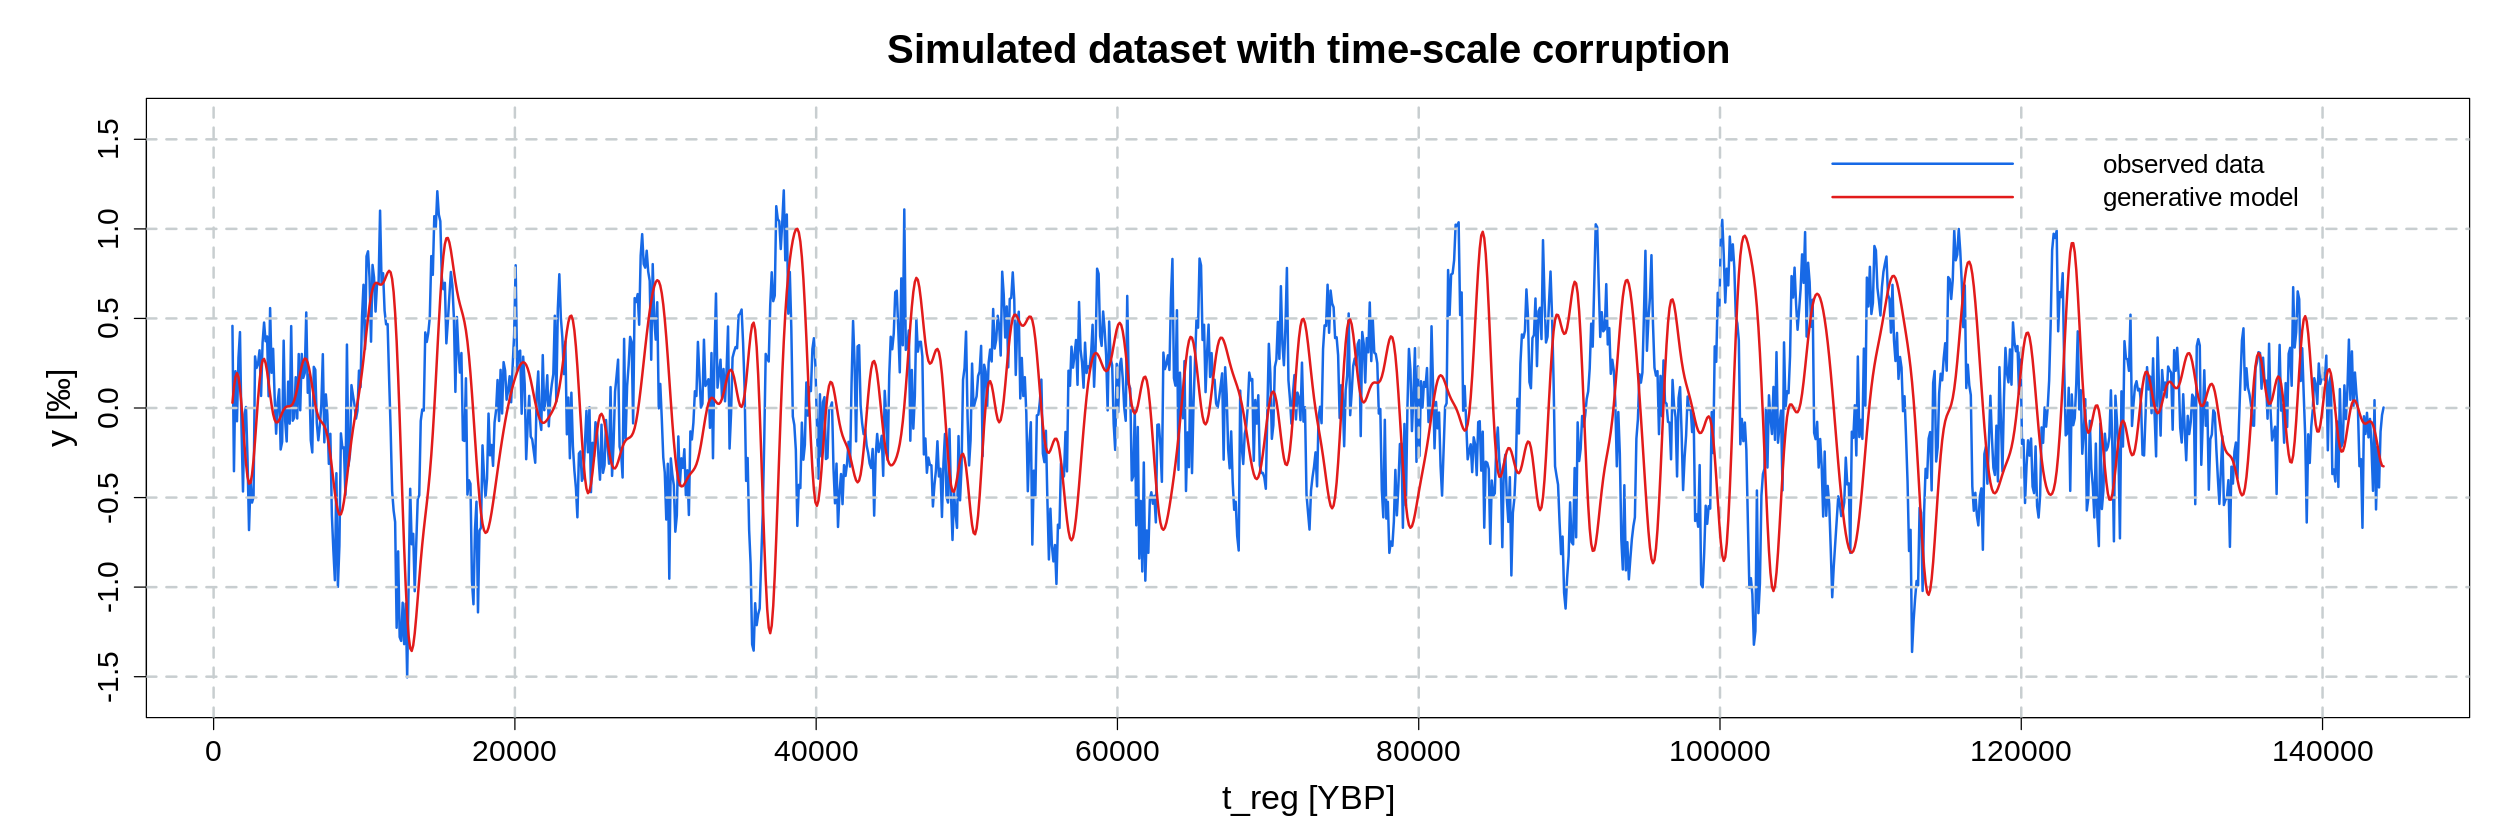

In [82]:
# plot simulation 
plot_simulation(t_reg, y_reg, data, 1, n)

In [13]:
# number of cycles to be inferred
N_cycle_inf <- 29

In [14]:
# initialization of time-dependant and constant parameters
data$init <- rep(100, length(data$xi))
param_init <- list('xi' = data[,c('step','init')], 'sigma_y' = 0.2)

param_A_init <- df_cycle[['A']][1:N_cycle_inf]
names(param_A_init) <- names(param_A)

param_ph_init <- df_cycle[['ph']][1:N_cycle_inf]
names(param_ph_init) <- names(param_ph)

param_init <- c(param_init, param_A_init, param_ph_init)

In [15]:
# ranges of constant parameters
param_range <- list('sigma_y' = c(0,1))

# A parameters range
param_A_range <- NULL
for (i in 1:N_cycle_inf) {
    temp <-  list(c(0,0.5))
    names(temp) <- paste0('A.',i)
    param_A_range <- append(param_A_range, temp) 
}

# ph parameters range
param_ph_range <- NULL
for (i in 1:N_cycle_inf) {
    temp <- list(c(0,2*pi))
    names(temp) <- paste0('ph.',i)
    param_ph_range <- append(param_ph_range, temp) 
}

param_range <- c(param_range, param_A_range, param_ph_range)

In [16]:
# define observational likelihood
loglikeli <- function(param, data) {

    # get parameter xi at time points of observations
    xi <- param$xi

    if ( is.matrix(xi) | is.data.frame(xi) ) {
        xi <- approx(x = xi[,1], y = xi[,2], xout = data[['step']])$y
    }

    # corrupted time
    t_corr <- rep(0, n)
    t_corr[1] <- 1250
    for (i in 2:n) {
            t_corr[i] <- t_corr[i-1] + xi[i]
    }

    # corrupted model
    y_corr <- rep(0, length(t_corr))
    for (i in 1:N_cycle_inf) {
        y_corr <- y_corr + param[[paste0('A.',i)]]*cos(2*pi*freq[i]*t_corr + param[[paste0('ph.',i)]])
    }

    # calculate likelihood
    log_likelihood_y <- sum(dnorm(data[['y_corr_obs']], mean = y_corr, sd = param$sigma_y, log = T))

    # return result
    return(log_likelihood_y)
    
}

In [17]:
# define priors for Orstein-Uhlenbeck parameters
logprior_ou <- function(param_ou) {

    # calculate priors
    log_prior_mean <- dnorm(param_ou[['xi_mean']], mean = 100, sd = 1, log = T)
    log_prior_sd <- dgamma(param_ou[['xi_sd']], shape = 1, rate = 1, log = T)
    log_prior_gamma <- dinvgamma(param_ou[['xi_gamma']], shape = 25, rate = 0.0025, log = T)

    # return result
    return(log_prior_mean + log_prior_sd + log_prior_gamma)

}

In [18]:
# define priors for constant parameters
logprior_const <- function(param_const) {

    # calculate priors
    log_prior_sigma_y <- dgamma(param_const[['sigma_y']], shape = 2, rate = 10, log = T)

    # return result
    return(log_prior_sigma_y)

}

In [19]:
# timedeppar settings for MCMC
n_iter <- 200000
n_interval <- 20
n_adapt <- floor(0.2*n_iter)
name = 'run_synthetic'

In [20]:
# bayesian inference
res <- NULL

if (FALSE) {

    res <- infer.timedeppar(loglikeli = loglikeli, 
                        param.ini = param_init,
                        param.range = param_range,
                        param.logprior = logprior_const,
                        param.ou.ini = c(xi_mean = 100, xi_sd = 1, xi_gamma = 1/1000),
                        param.ou.logprior = logprior_ou,
                        n.iter = n_iter,
                        control = list(n.interval = n_interval, n.adapt = n_adapt),
                        file.save = name,
                        data = data)

}


# Results

In [21]:
# import inferred dataframe
load(paste0(name, '.RData'))

In [22]:
# remove burn in and apply thinning
start <- 1 + n_adapt + 1
end <- n_iter + 1
thinning <- 10

In [23]:
# collect parameters
df_inf_ou <- as.data.frame(res$sample.param.ou[seq(start, end, thinning),])
df_inf_const <- as.data.frame(res$sample.param.const[seq(start, end, thinning),])
df_inf_timedep <- as.data.frame(res$sample.param.timedep[[1]][seq(start+1, end+1, thinning),])
names(df_inf_timedep) <- paste0(rep('xi.', n), as.character(seq(1, n)))
df_inf <- cbind(df_inf_ou, df_inf_const, df_inf_timedep)

In [24]:
# compute samples of t parameters from xi parameters
df_inf['t.1'] <- rep(1250, nrow(df_inf))

for (i in 2:n) {
	df_inf[paste0('t.',i)] <- df_inf[paste0('t.',(i-1))] + df_inf[paste0('xi.',i)]
}

In [25]:
infer_parameter <- function(names, df) {

    param_inf <- NULL

    for (name in names) {
        temp <- quantile(df[[name]], probs = 0.5)
        names(temp) <- name
        param_inf <- append(param_inf, temp)
    }

    return(param_inf)

}

In [26]:
# Orstein-Uhlenbeck inferred parameters
param_OU_inf = infer_parameter(names(param_OU), df_inf)

# sigma_y inferred parameter
param_sigma_y_inf = infer_parameter(names(param_sigma_y), df_inf)

# A inferred parameters
param_A_inf = infer_parameter(names(param_A)[1:N_cycle_inf], df_inf)

# ph inferred parameters
param_ph_inf = infer_parameter(names(param_ph)[1:N_cycle_inf], df_inf)

# t inferred parameters
param_t_inf = infer_parameter(names(param_t), df_inf)

# concatenate named vectors
param_inf <- c(param_OU_inf, param_sigma_y_inf, param_A_inf, param_ph_inf)

In [27]:
# print true and inferred parameters
for (name in names(param_inf)) {

    cat(name, '\n')

    prec <- NULL

    if (is.element(name, c('xi_mean', 'xi_sd'))) {
        prec <- 1
    }
    else if (is.element(name, c('xi_gamma'))) {
        prec <- 5
    }
    else if (is.element(name, c('sigma_y'))) {
        prec <- 3
    }
    else if (is.element(name, paste0(rep('A.', N_cycle_inf), as.character(seq(1, N_cycle_inf))))) {
        prec <- 3
    }
    else if (is.element(name, paste0(rep('ph.', N_cycle_inf), as.character(seq(1, N_cycle_inf))))) {
        prec <- 2
    }

    cat('true: ', round(param[name], prec),
        ' inf: ', round(param_inf[name], prec),
        ' +- ', round(sqrt(var(df_inf[name])), prec), '\n', sep = '')
}

xi_mean 
true: 100 inf: 100.1 +- 0.9
xi_sd 
true: 5 inf: 5.2 +- 0.8
xi_gamma 
true: 0.00067 inf: 0.00012 +- 3e-05
sigma_y 
true: 0.2 inf: 0.201 +- 0.004
A.1 
true: 0.183 inf: 0.192 +- 0.009
A.2 
true: 0.179 inf: 0.181 +- 0.008
A.3 
true: 0.15 inf: 0.151 +- 0.009
A.4 
true: 0.144 inf: 0.133 +- 0.008
A.5 
true: 0.138 inf: 0.156 +- 0.008
A.6 
true: 0.112 inf: 0.101 +- 0.008
A.7 
true: 0.124 inf: 0.121 +- 0.009
A.8 
true: 0.109 inf: 0.117 +- 0.009
A.9 
true: 0.11 inf: 0.094 +- 0.009
A.10 
true: 0.095 inf: 0.09 +- 0.008
A.11 
true: 0.105 inf: 0.11 +- 0.008
A.12 
true: 0.118 inf: 0.121 +- 0.008
A.13 
true: 0.102 inf: 0.113 +- 0.01
A.14 
true: 0.103 inf: 0.094 +- 0.01
A.15 
true: 0.084 inf: 0.082 +- 0.009
A.16 
true: 0.098 inf: 0.089 +- 0.009
A.17 
true: 0.078 inf: 0.073 +- 0.009
A.18 
true: 0.085 inf: 0.081 +- 0.009
A.19 
true: 0.093 inf: 0.099 +- 0.009
A.20 
true: 0.078 inf: 0.086 +- 0.008
A.21 
true: 0.081 inf: 0.07 +- 0.008
A.22 
true: 0.088 inf: 0.088 +- 0.008
A.23 
true: 0.065 inf: 0.06

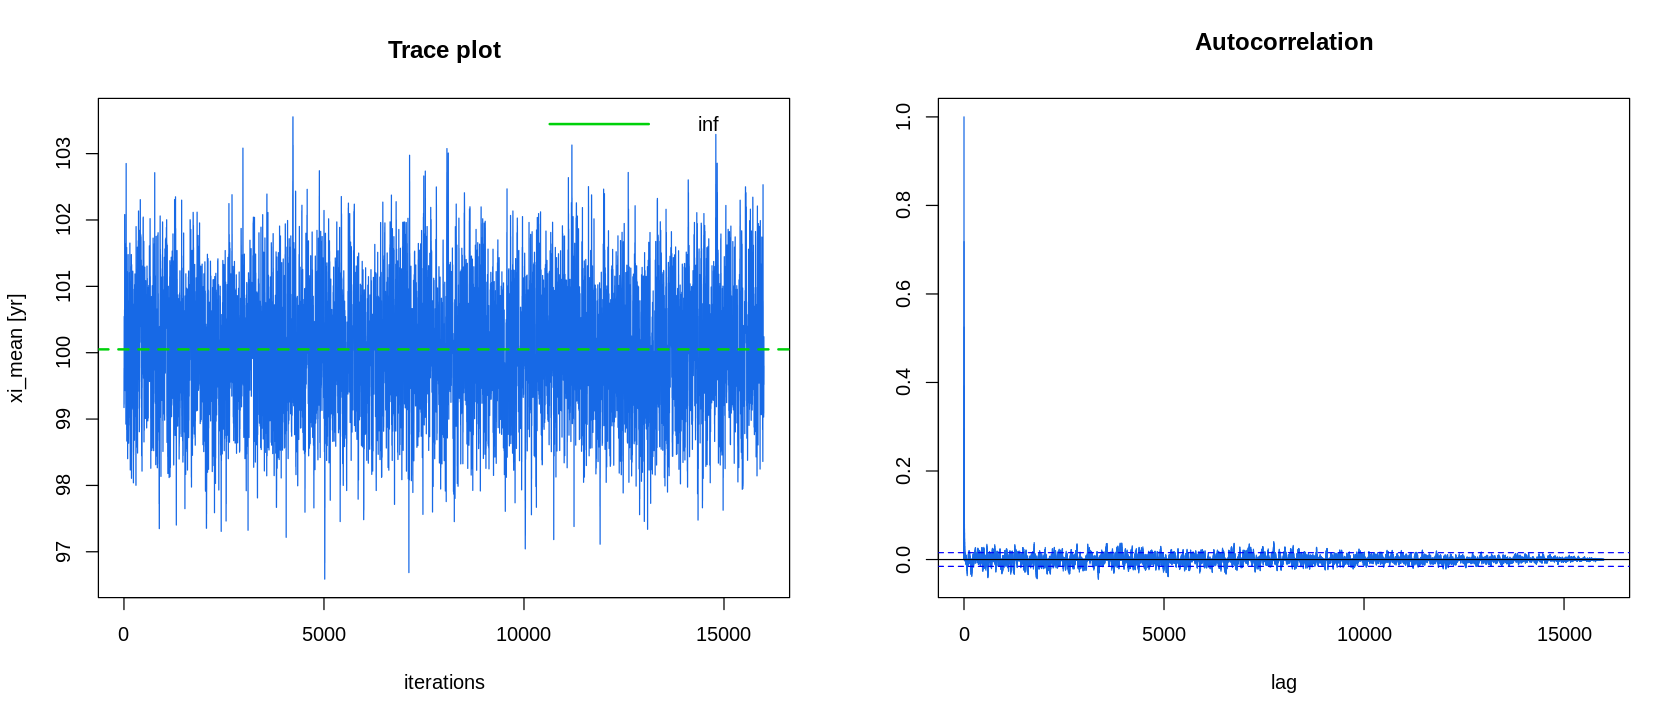

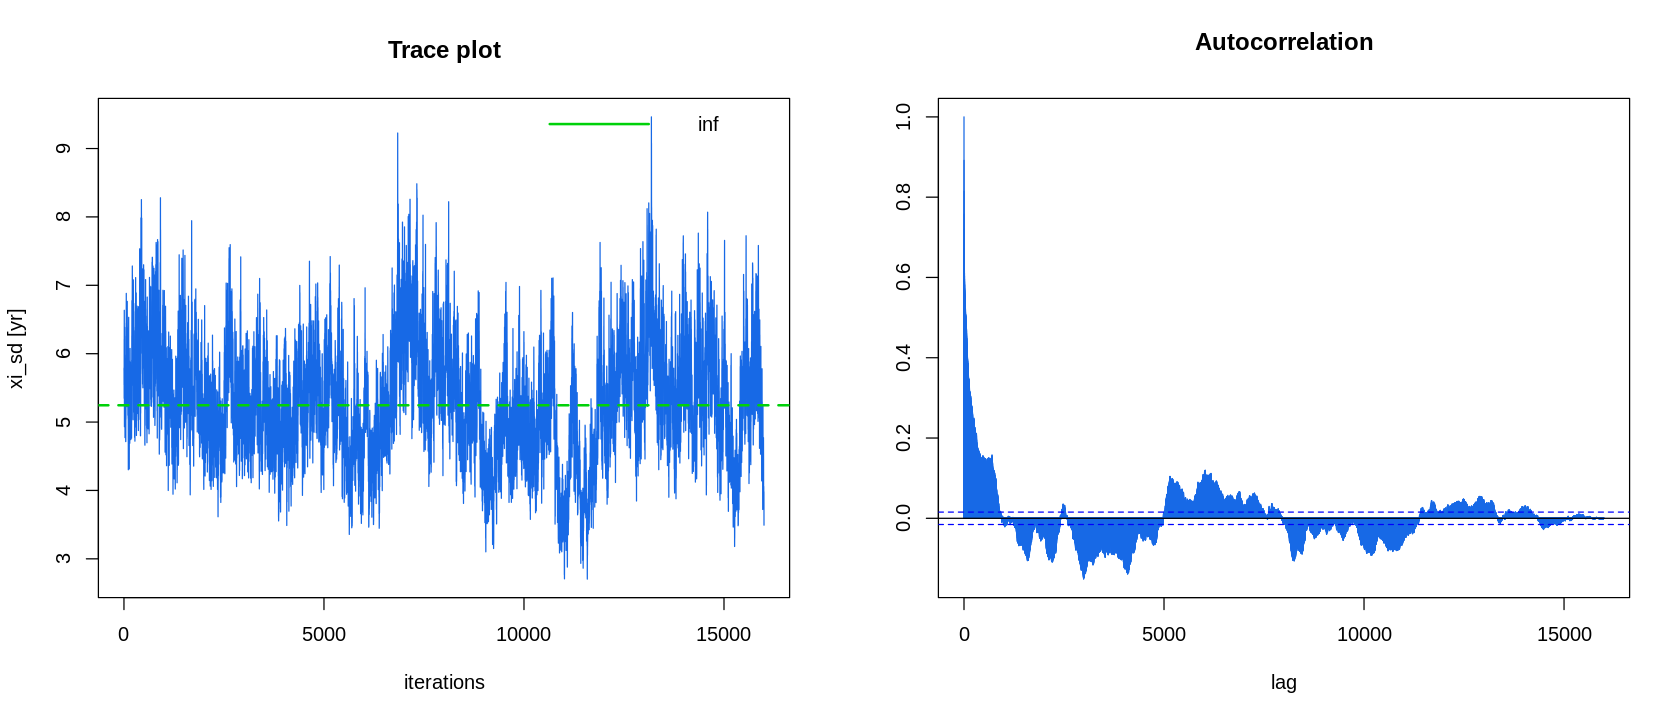

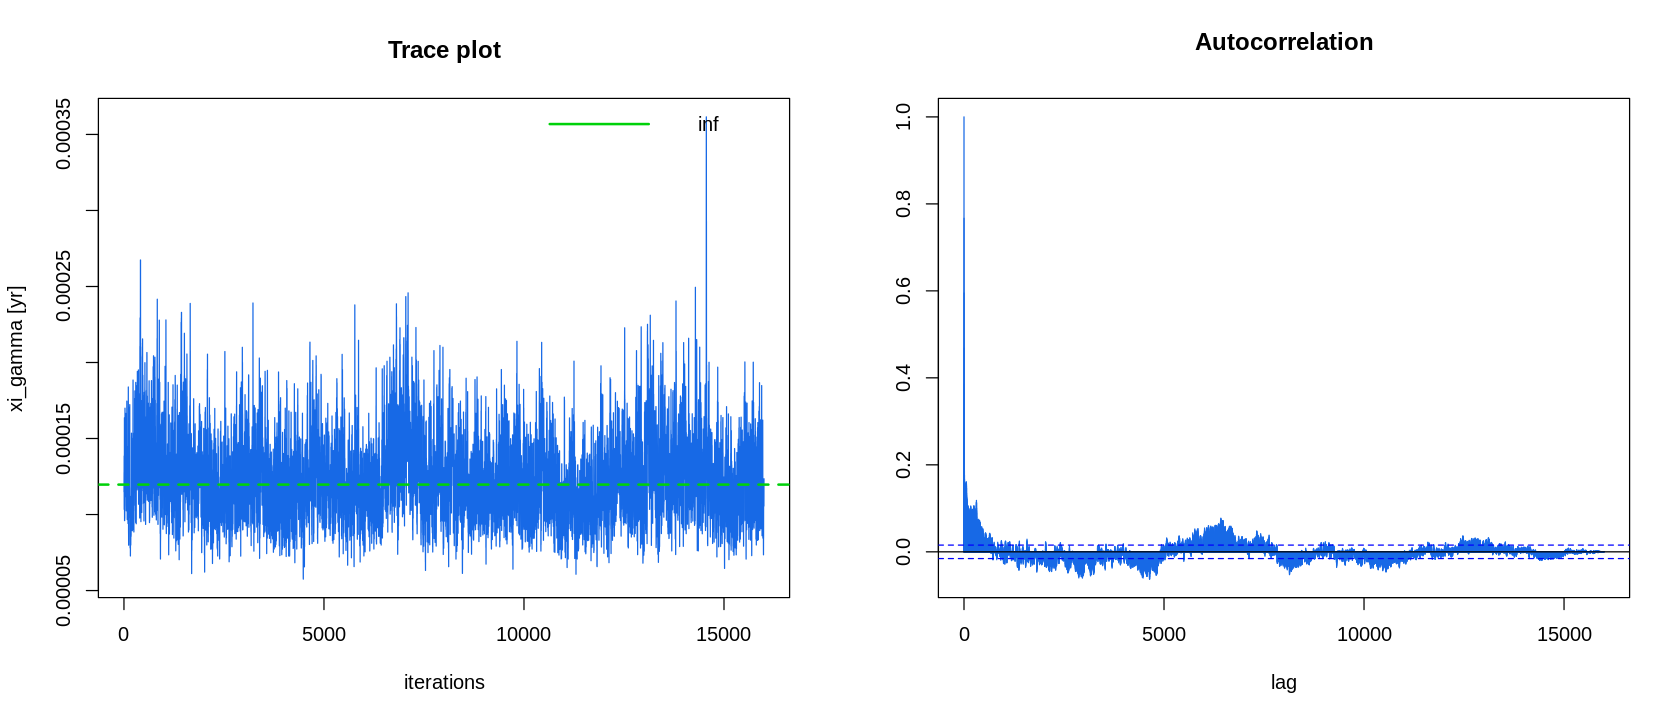

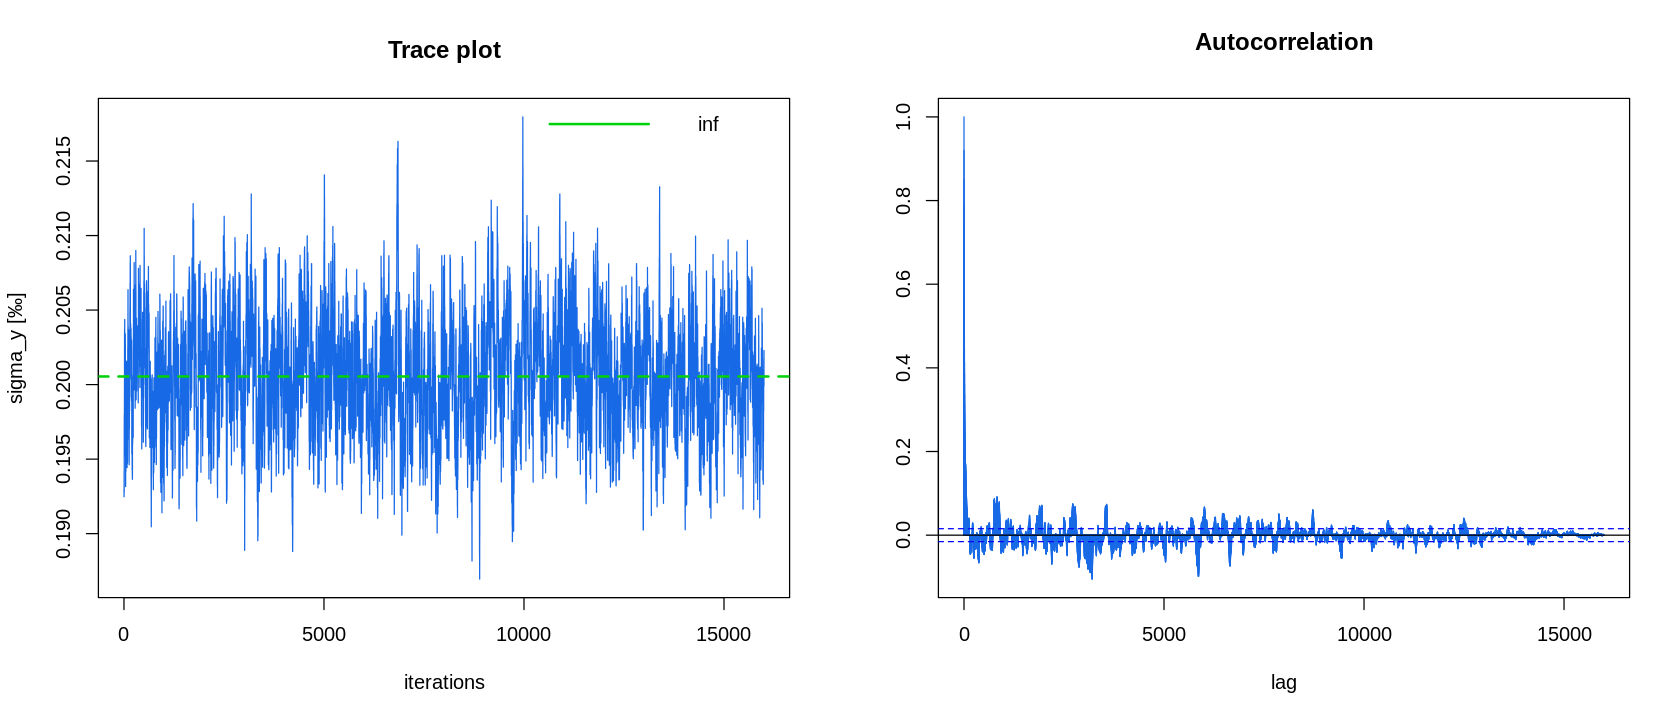

In [83]:
plot_mc_acf <- function(df, key) {

    # plot
    options(repr.plot.width = 14, repr.plot.height = 6)
    par(mfrow = c(1,2))

    if( key == 'sigma_y'){
    # markov chain
    plot(seq(1, nrow(df)), df[[key]],
        main = 'Trace plot',
        xlab = 'iterations', ylab = paste(key, '[‰]'), type = 'l', col = col_blue) }

    else{
    # markov chain
    plot(seq(1, nrow(df)), df[[key]],
        main = 'Trace plot',
        xlab = 'iterations', ylab = paste(key, '[yr]'), type = 'l', col = col_blue)}

    

    abline(h = median(df[[key]]), col = col_green, lty = 2, lwd = 2)

    legend(x = 'topright', bty = 'n',
    inset = 0.01,
    legend = c('inf'),
    lty = rep(1,1),
    col = c(col_green),
    lwd = rep(2,1))

    # autocorrelation
    acf(df[[key]], lag = length(df[[key]]) - 1,
        main = 'Autocorrelation', xlab = 'lag', ylab = '', col = col_blue)
        
}


for (name in names(c(param_OU_inf, param_sigma_y_inf))) {
    plot_mc_acf(df_inf, name)
}

In [84]:
# plot pairwise scatter plot matrix, histograms and correlation coefficients
scatterplot_matrix <- function(param_inf, n, df) {

    # Orstein-Uhlenbeck and sigma_y
    key <- names(param_inf)[1:4]

    # A
    key <- c(key, paste0(rep('A.', n), as.character(seq(1, n))))

    # ph
    key <- c(key, paste0(rep('ph.', n), as.character(seq(1, n))))

    # plot
    options(repr.plot.width = 16, repr.plot.height = 16)
    par(mar = c(1.5, 2, 1, 1))

    # layout matrix
    n <- 1
    mat <- matrix(0, length(key), length(key))

    # rows
    for (i in 1:length(key)) {

        # columns
        for (j in 1:length(key)) {

            if(j<=i) {
                mat[i,j] <- n
                n <- n + 1
            }
        }
    }

    layout(mat)

    # rows
    for (i in 1:length(key)) {

        # columns
        for (j in 1:length(key)) {

            # histograms
            if (j==i) {
                hist(df[[key[i]]], breaks = 20,
                    main = key[i], col = col_blue)
                box()
                grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 1)
                abline(v = param_inf[[key[i]]], col = col_green, lty = 2, lwd = 2)
            }

            # scatter plots
            else if (j<i) {
                plot(df[[key[j]]], df[[key[i]]], col = col_blue)
                grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 1)
            }
        }
    }
}

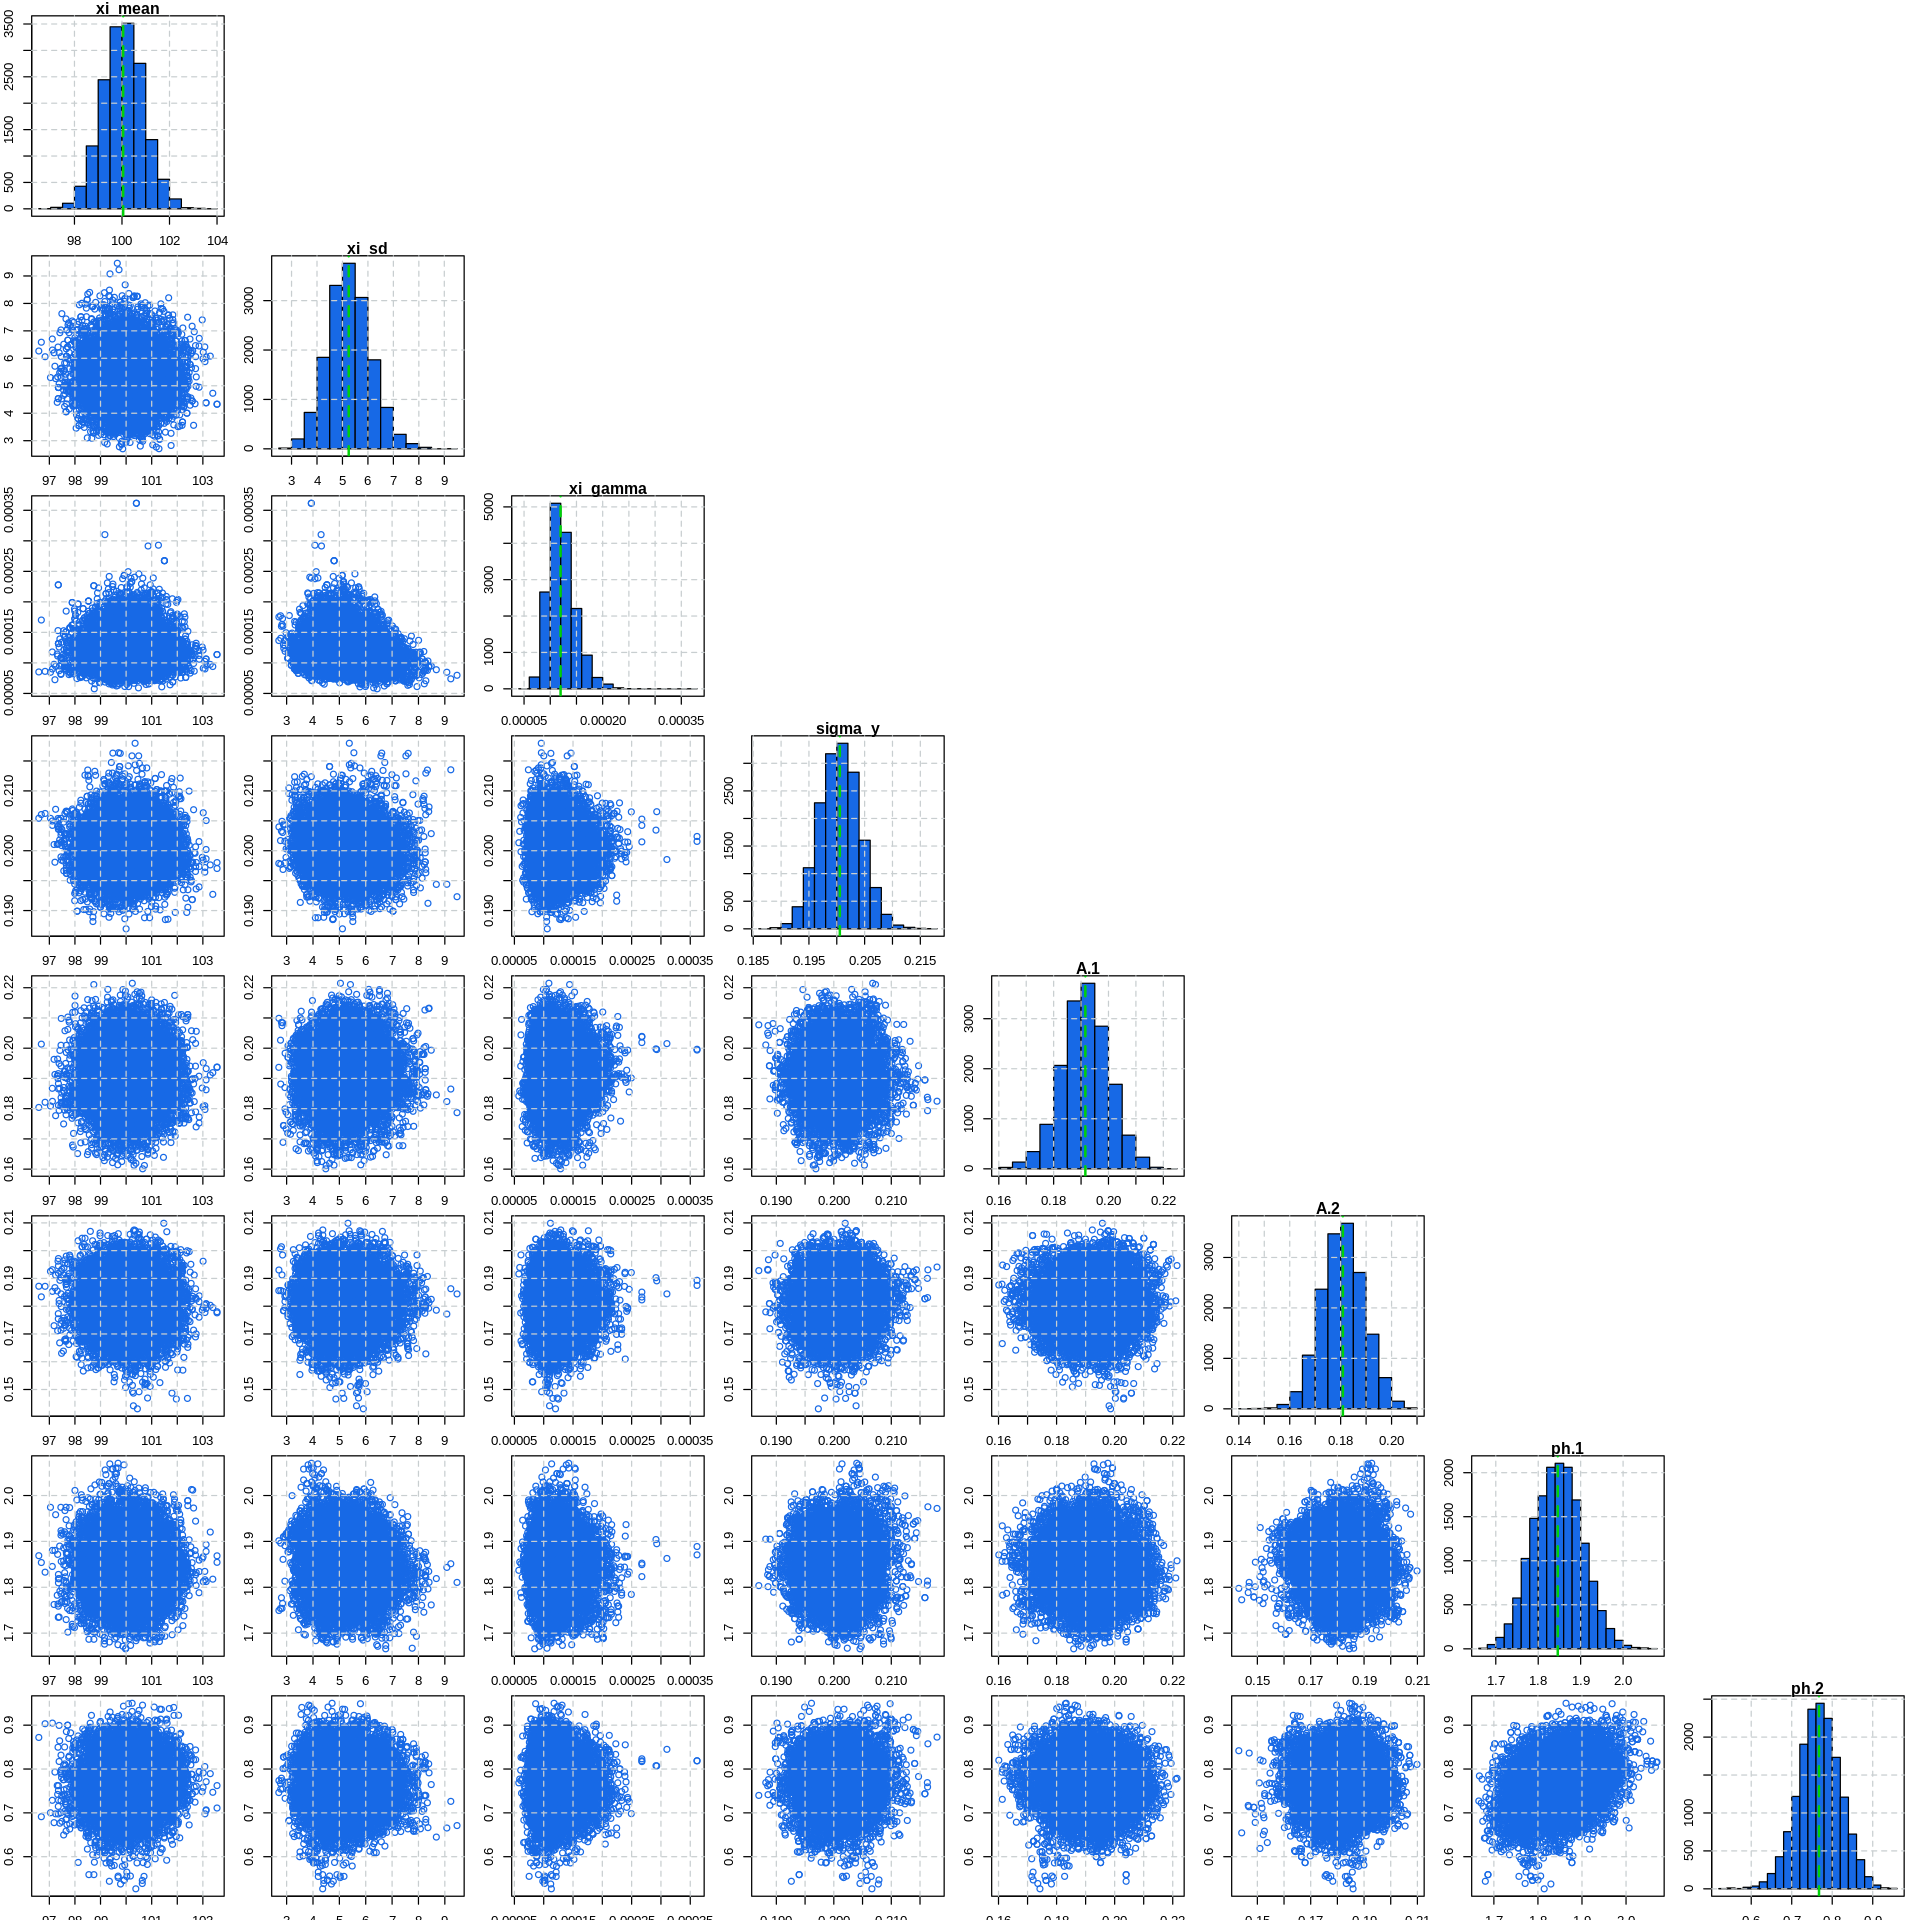

In [30]:
# pairwise scatter plot matrix, histograms (marginals) and correlation coefficients
scatterplot_matrix(param_inf, 2, df_inf)

In [101]:
# plot inferred Orstein-Uhlenbeck model
infer_OU <- function(data, df) {

    names <- paste0(rep('xi.', n), as.character(seq(1, n)))

    # xi inferred parameters and 95% credible interval
    xi_inf <- apply(df[names], 2, quantile, probs = 0.5)
    xi_inf_95CI <- apply(df[names], 2, quantile, probs = c(0.025, 0.975))

    # plot
    options(repr.plot.width = 18, repr.plot.height = 8)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    plot(data$step, data$xi, ylim = mean + 5*c(-sd, sd),
        main = 'Inferred Orstein-Uhlenbeck process',
        xlab = 't_reg [YBP]', ylab = 'ξ [yr]',
        type = 'l', lty = 1, lwd = 2, col = col_blue,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 2)

    polygon(c(data$step, rev(data$step)), 
            c(xi_inf_95CI[1,], rev(xi_inf_95CI[2,])),
            col = col_grey, density = 75, border = FALSE)

    abline(h = mean, col = 'black', lty = 2, lwd = 2)

    lines(data$step, data$xi, type = 'l', lty = 1, lwd = 2, col = col_blue)

    lines(data$step, xi_inf, type = 'l', lty = 1, lwd = 3, col = col_green)

    legend(x = 0.70*n*100, y = mean + 0.82*(5*sd), bty = 'n',
        inset = 0.01,
        legend = c('simulation', 'inference', '95% CI'),
        lty = rep(1,3),
        col = c(col_blue, col_green, col_grey),
        lwd = rep(2,3),
        cex = 1.3)
}

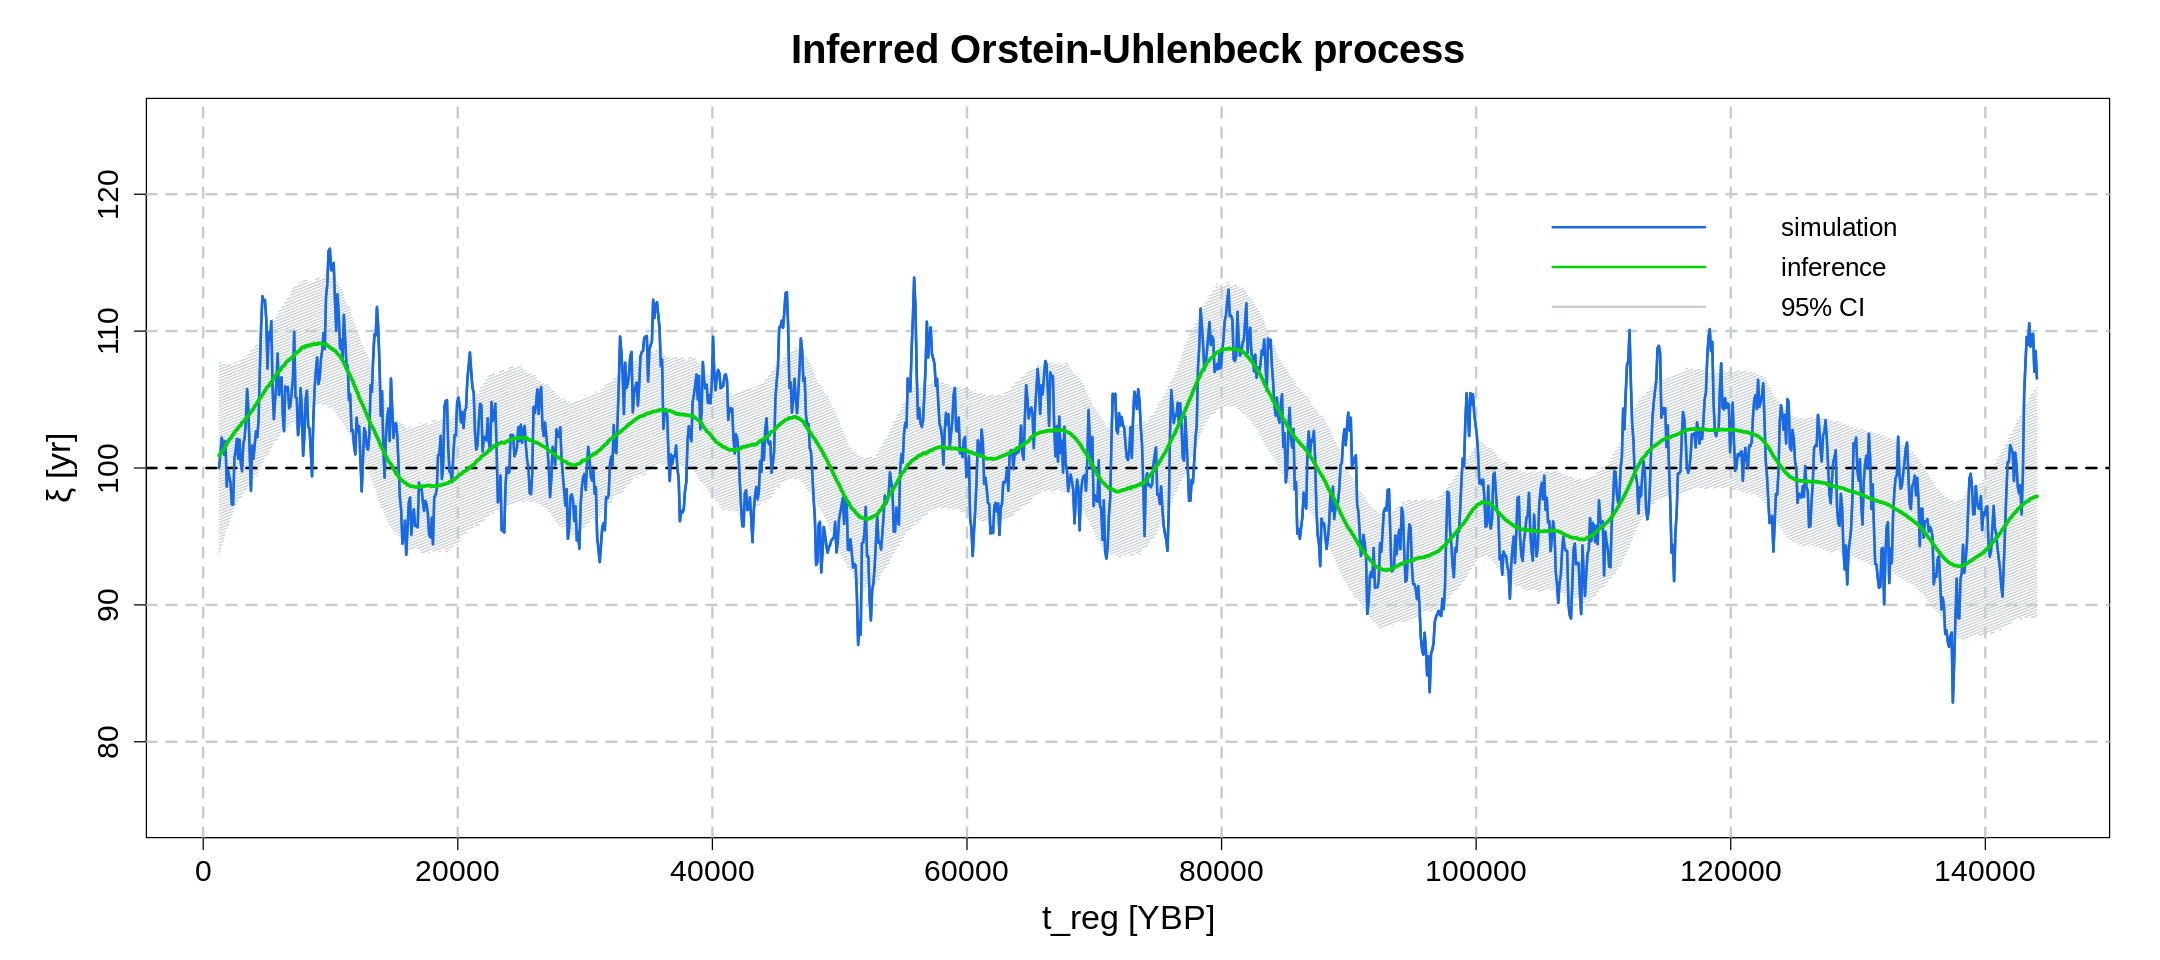

In [102]:
# plot inferred Orstein-Uhlenbeck model
infer_OU(data, df_inf)

In [103]:
# plot trace (Markov chain) and histogram (marginal) of a t inferred parameter
traceplot <- function(param_t, param_t_inf, i, df) {
    
    key <- paste0('t.', i)
    
    # plot
    options(repr.plot.width = 14, repr.plot.height = 6)
    par(mfrow = c(1,2))

    # trace
    
    plot(seq(1, nrow(df)), df[[key]], ylim = t_reg[i] + 250*c(-sd, sd),
        main = 'Trace plot', xlab = 'iterations', ylab = paste(key,'[yr]'), type = 'l', col = col_blue)

    abline(h = param_t[key], col = col_red, lty = 2, lwd = 2)
    abline(h = param_t_inf[key], col = col_green, lty = 2, lwd = 2)
    abline(h = t_reg[i], col = 'black', lty = 2, lwd = 2)

    legend(x = -0.05*nrow(df[key]), y = t_reg[i] - 0.7*250*sd, bty = 'n', inset = 0.01,
        legend = c(paste0('true ', key), paste0('inf ', key), paste0('reg ', key)),
        lty = rep(1,3), col = c(col_red,col_green, 'black'))

    # histogram
     
    h <- hist(df[[key]], breaks = 10,  xlim = t_reg[i] + 250*c(-sd, sd),
        main = 'Marginalized posterior histogram', xlab = paste(key,'[yr]'), col = col_blue)
    box()

    abline(v = param_t[key], col = col_red, lty = 2, lwd = 2)
    abline(v = param_t_inf[key], col = col_green, lty = 2, lwd = 2)
    abline(v = t_reg[i], col = 'black', lty = 2, lwd = 2)

    legend(x = t_reg[i] - 1.15*250*sd, y = 1.01*max(h$counts), bty = 'n', inset = 0.01,
        legend = c(paste0('true ', key), paste0('inf ', key), paste0('reg ', key)),
        lty = rep(1,3), col = c(col_red,col_green, 'black'))

}

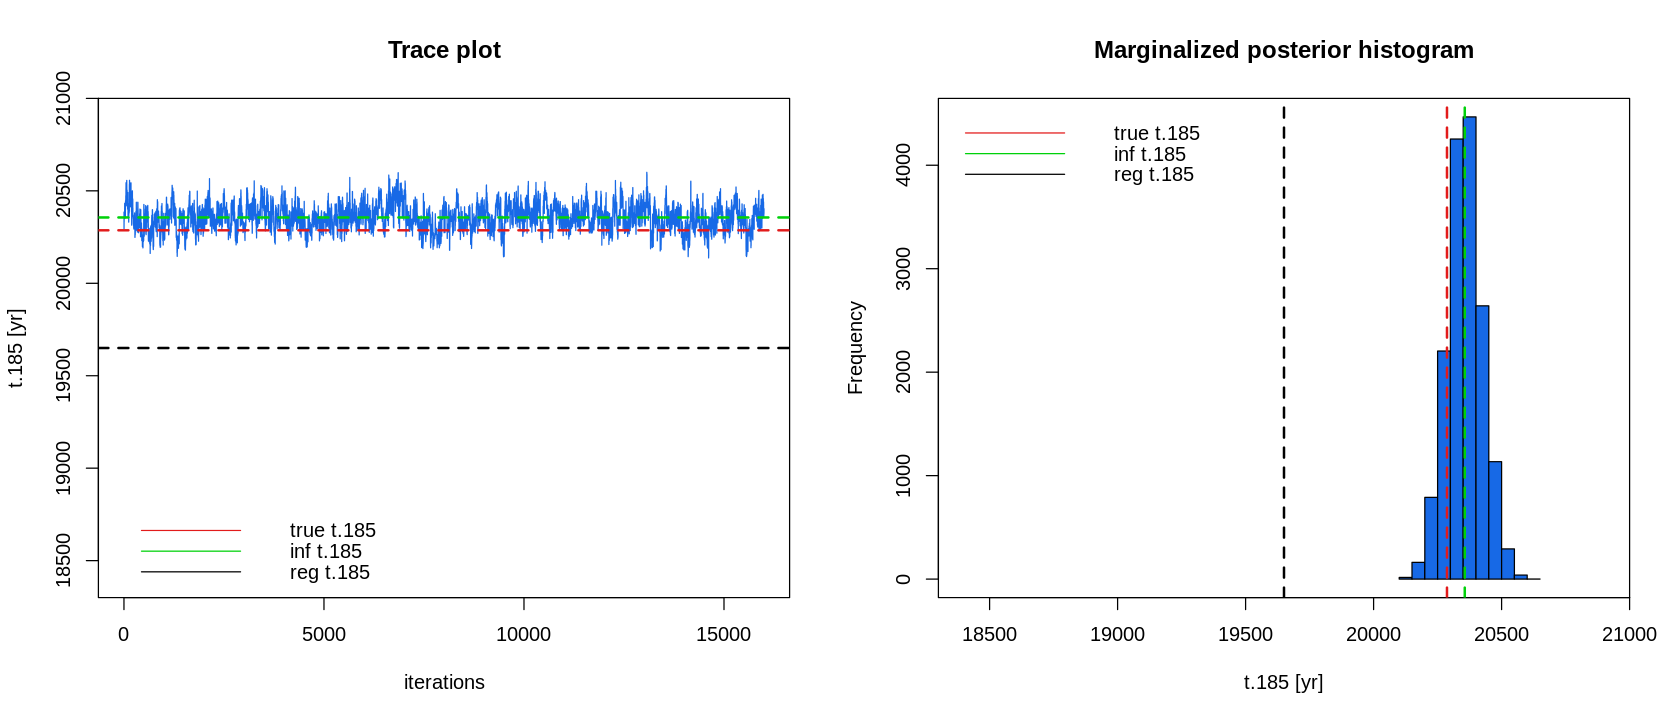

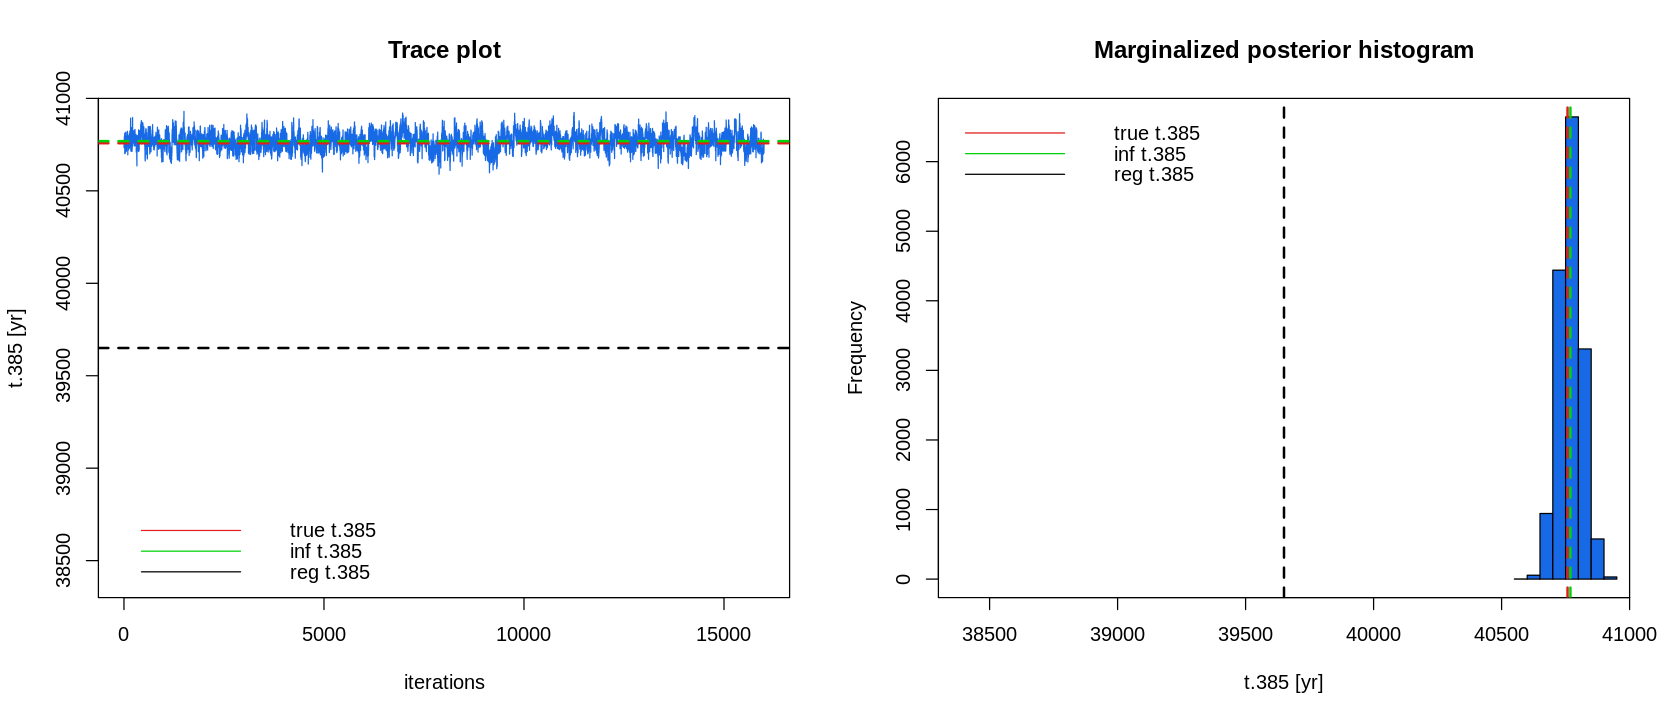

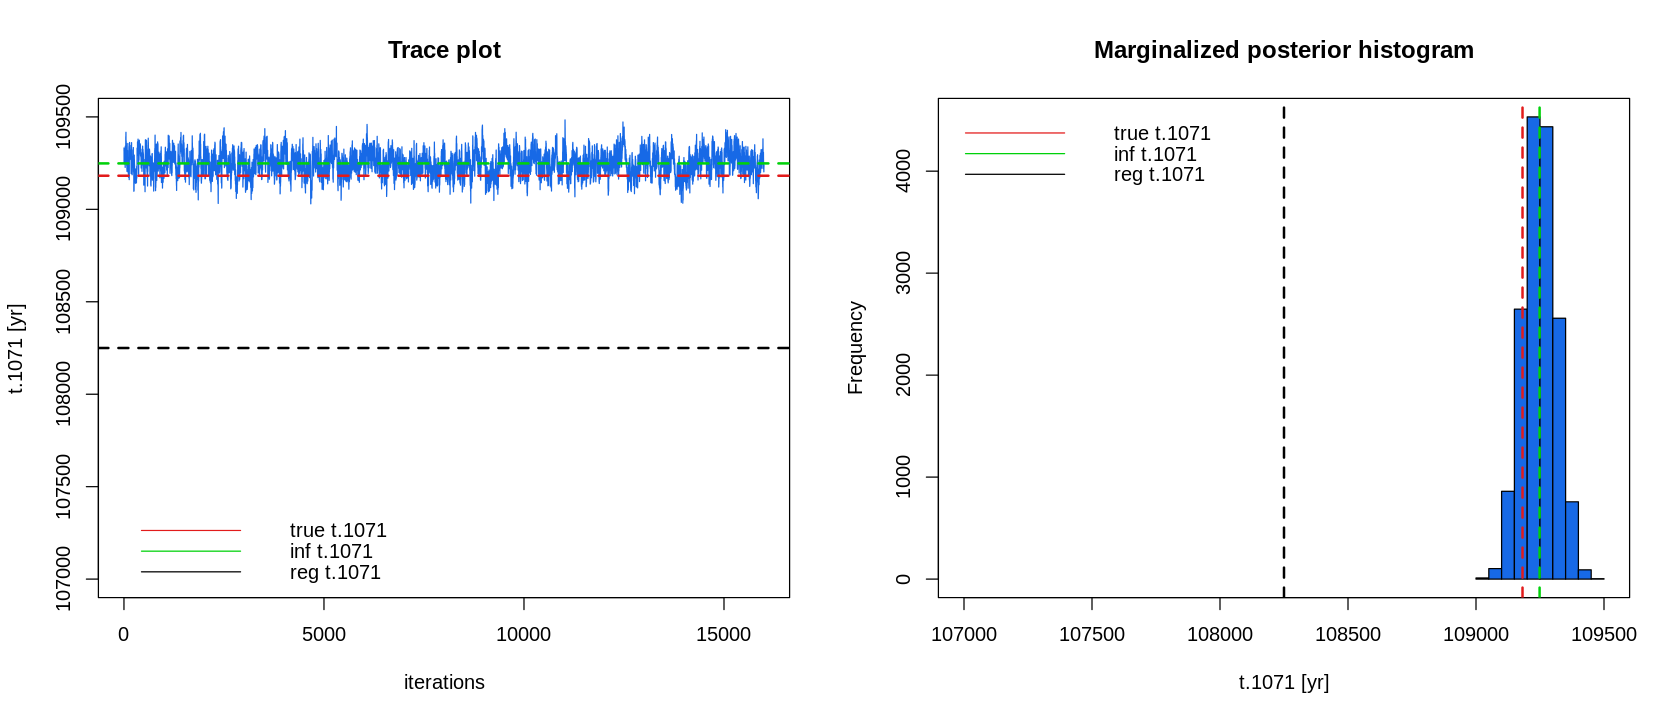

In [104]:
tis <- c(0.13*n, 0.27*n, 0.75*n)

for (i in tis) {
    traceplot(param_t, param_t_inf, as.integer(i), df_inf)
}

In [35]:
# 95% credible interval of t inferred parameters
param_t_inf_95CI <- apply(df_inf[names(param_t_inf)], 2, quantile, probs = c(0.025, 0.975))

In [111]:
# plot credible interval of all t inferred parameters
credible_interval <- function(t_reg, param_t, param_t_inf, param_t_inf_95CI) {

    # shifted true value
    y_true <- param_t - t_reg
    # shifted inferred value
    y_inf <- param_t_inf - t_reg

    # plot
    options(repr.plot.width = 18, repr.plot.height = 8)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    plot(seq(1, length(y_true)), y_true, ylim = max(y_true)*c(0, 1.1),
        main = 'Difference between the corrupted and regular time-scale',
        xlab = 'index', ylab = 'Δt [yr]',
        type = 'l', lty = 1, lwd = 2, col = col_blue,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 2)

    polygon(c(seq(1, length(y_inf)), rev(seq(1, length(y_inf)))), 
            c(param_t_inf_95CI[1,] - t_reg, rev(param_t_inf_95CI[2,] - t_reg)),
            col = col_grey, density = 90, border = FALSE)

    abline(h = 0, col = 'black', lty = 2, lwd = 2)

    lines(seq(1, length(y_true)), y_true, type = 'l', lty = 1, lwd = 2, col = col_blue)

    lines(seq(1, length(y_inf)), y_inf, type = 'l', lty = 1, lwd = 2, col = col_green)

    legend(x = 0.71*n, y = 1*max(y_true), bty = 'n',
        inset = 0.01,
        legend = c('simulation', 'inference', '95% CI'),
        lty = rep(1,3),
        col = c(col_blue, col_green, col_grey),
        lwd = rep(2,3),
        cex = 1.3)

}

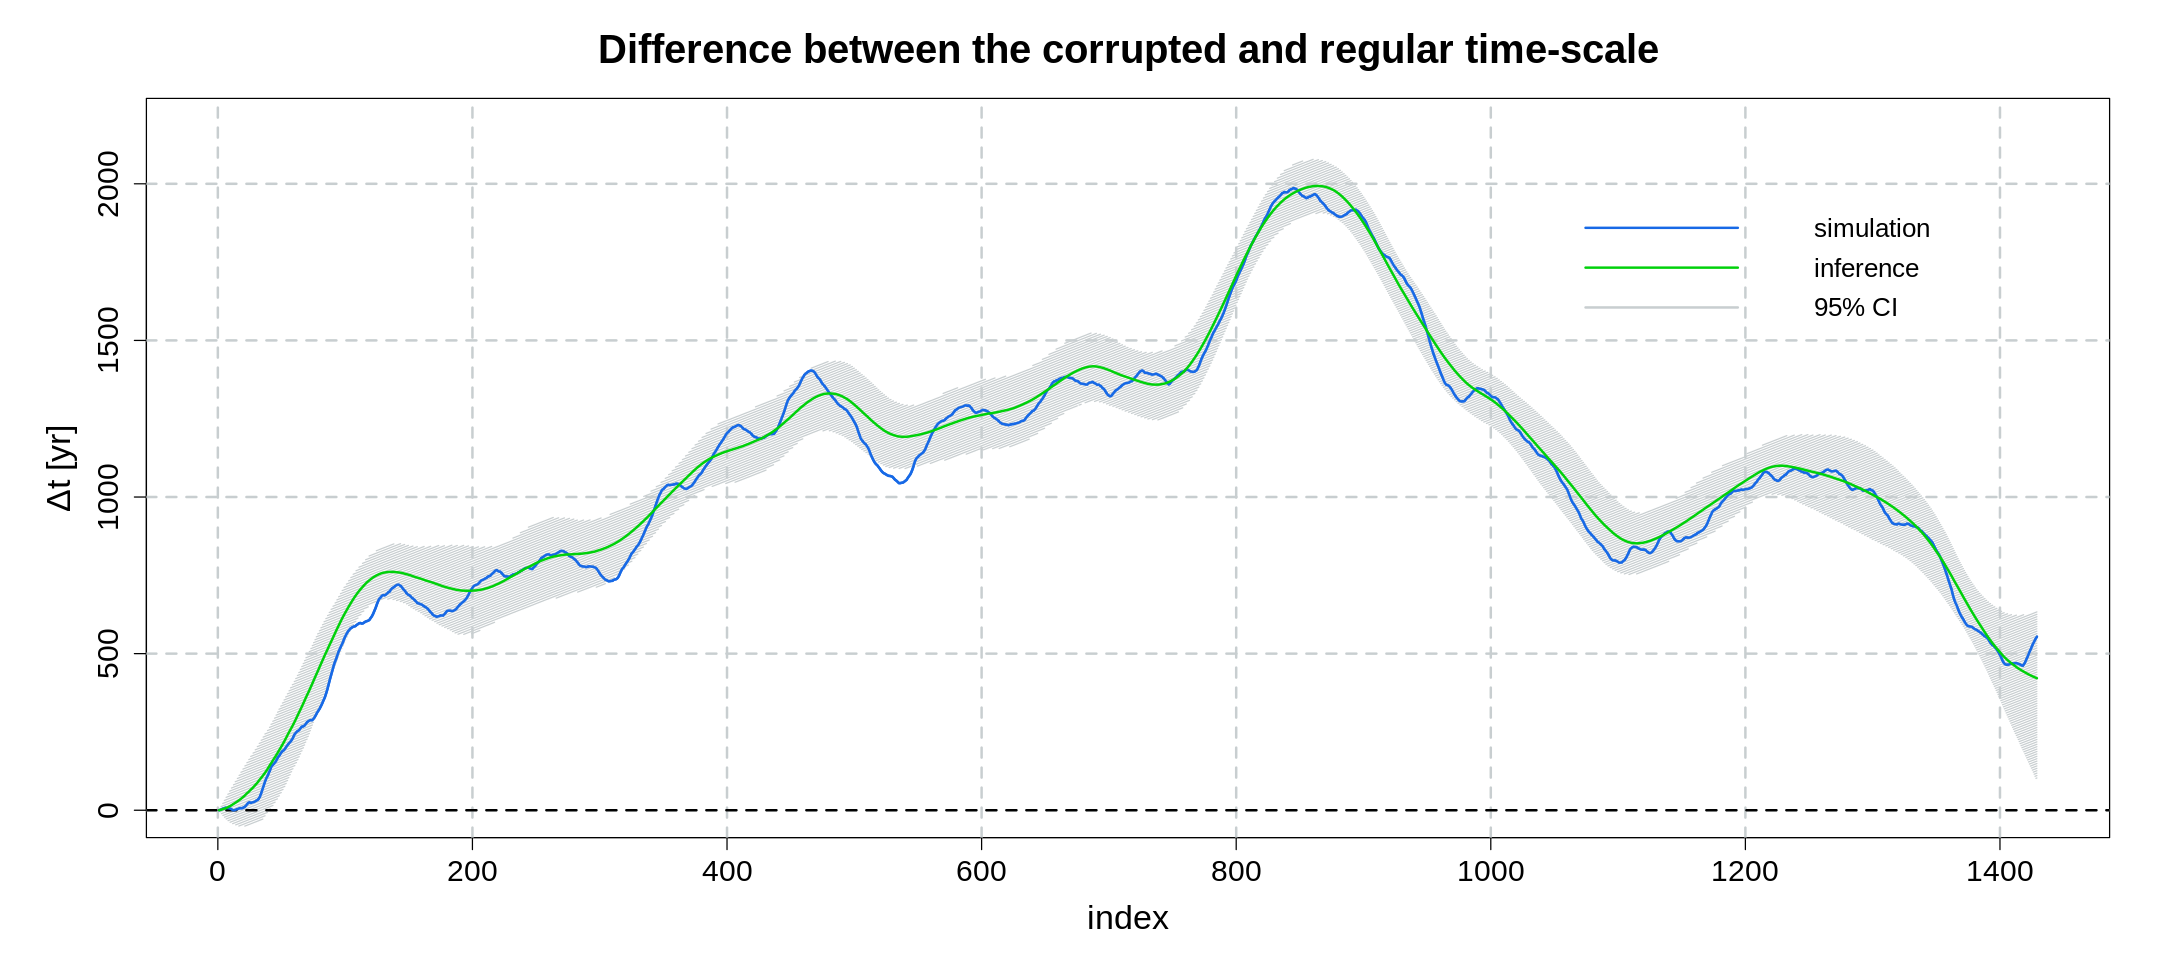

In [112]:
credible_interval(t_reg, param_t, param_t_inf, param_t_inf_95CI)

In [38]:
# compute fit
fit_data <- function(param_A_inf, param_ph_inf, param_t_inf, freq, N_cycle_inf, n) {

    A <- unname(param_A_inf)
    ph <- unname(param_ph_inf)
    t <- unname(param_t_inf)

    fit <- rep(0, n) 
    for (i in seq(1, N_cycle_inf)) {
        fit <- fit + A[i]*cos(2*pi*freq[i]*t + ph[i])
    }

    return(fit)
}

In [39]:
# compute fit
fit <- fit_data(param_A_inf, param_ph_inf, param_t_inf, freq, N_cycle_inf, n)

In [117]:
plot_fit <- function(t_reg, data, fit, start, end) {

    t_reg <- t_reg[start:end]
    data <- data[start:end,]
    fit <- fit[start:end]

    # plot
    options(repr.plot.width = 21, repr.plot.height = 7)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    plot(t_reg, data$y_corr_obs, ylim = (max(fit) + 3*sigma_y)*c(-1,1),
        main = 'Simulated dataset with inferred fit',
        xlab = 't_reg [YBP]', ylab = 'y [‰]',
        type = 'l', lty = 1, lwd = 2, col = col_blue,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 2)

    lines(t_reg, fit, type = 'l', lty = 1, lwd = 2, col = col_green)

    legend(x = start*100 + 0.71*(end-start)*100, y = 1.55, bty = 'n',
        inset = 0.02,
        legend = c('observed data', 'fit'),
        lty = rep(1,2),
        col = c(col_blue, col_green),
        lwd = rep(2,2),
        cex = 1.3)

}

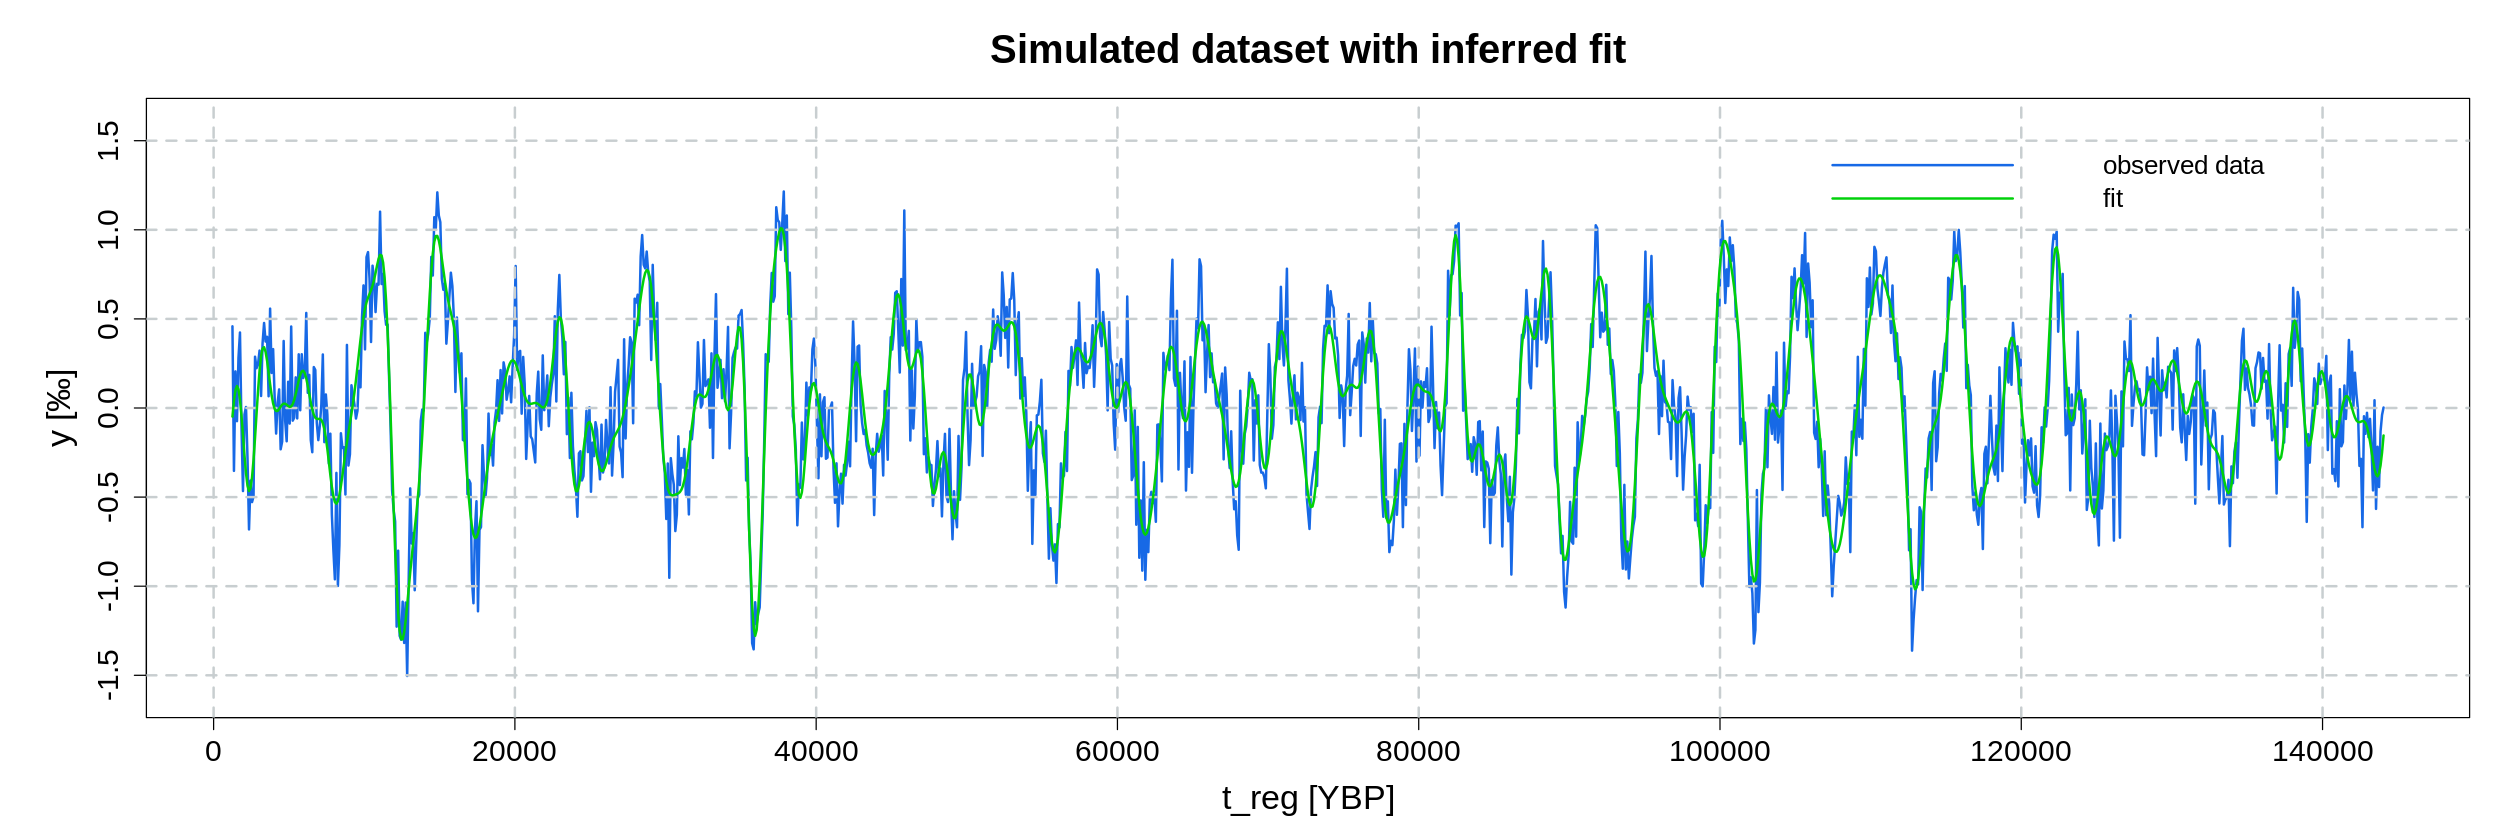

In [118]:
plot_fit(t_reg, data, fit, 1, n)

In [135]:
plot_inference <- function(t_reg, t_inf, y_reg, data, start, end) {

    t_reg <- t_reg[start:end]
    t_inf <- t_inf[start:end]
    y_reg <- y_reg[start:end]
    data <- data[start:end,]

    # plot
    options(repr.plot.width = 18, repr.plot.height = 8)
    par(mar = c(5.1, 6.1, 4.1, 2.1))

    plot(t_reg, data$y_corr_obs,
        ylim = (max(y_reg) + 3*sigma_y)*c(-1,1),
        main = 'Time-scale correction',
        xlab = 't [YBP]', ylab = 'y [‰]',
        type = 'l', lty = 1, lwd = 2, col = col_blue,
        cex.main = 2, cex.lab = 1.7, cex.axis = 1.5)

    grid(nx = NULL, ny = NULL, lty = 2, col = col_grey, lwd = 2)

    lines(t_reg, y_reg,
        type = 'l', lty = 1, lwd = 2, col = col_red)

    lines(t_inf, data$y_corr_obs,
        type = 'l', lty = 1, lwd = 2, col = col_green)

    legend(x = start*100 + 0.72*(end-start)*100, y = 1.63, bty = 'n',
        inset = 0.02,
        legend = c('observed data', 'generative model', 'corrected data'),
        lty = rep(1,3),
        col = c(col_blue, col_red, col_green),
        lwd = rep(2,3),
        cex = 1.3)
}

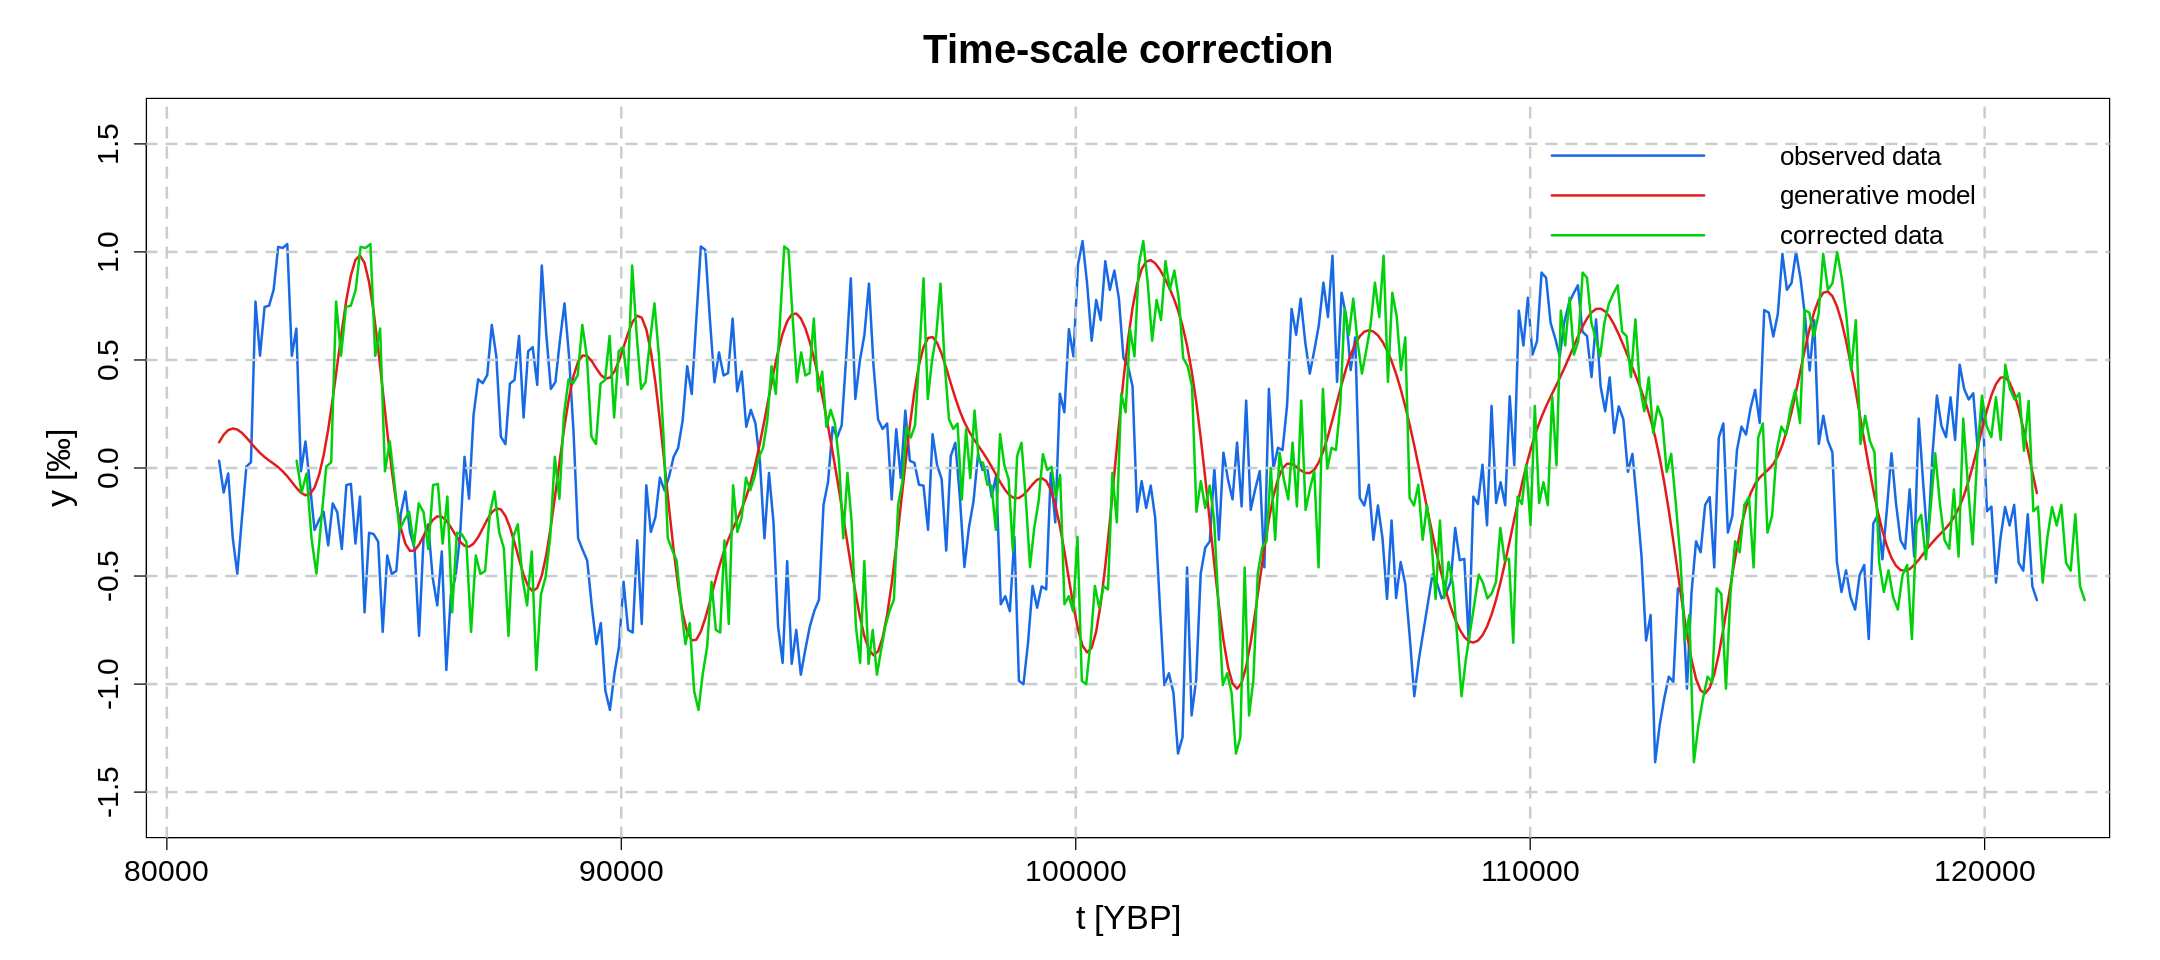

In [136]:
plot_inference(t_reg, param_t_inf, y_reg, data, 800, 1200)

In [44]:
# time scale correction
ssr <- sum((t_corr - t_reg)**2)
ssr_inf <- sum((t_corr - param_t_inf)**2)
error_reduction <- (ssr - ssr_inf)/ssr
cat('simulation ssr:', ssr, '\n')
cat('inference ssr:', ssr_inf, '\n')
cat('percentage error reduction', round(error_reduction, 4))

simulation ssr: 1866253891 
inference ssr: 3750324 
percentage error reduction 0.998

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ec568eb4-d450-47fb-8040-ef79e7ad074e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>